In [1]:
#Import python packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.semi_parametric import CoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score

#import our functions
from cleaning import cleaning
import error_function
from lasso import rmse_cv,Lasso_importance

# Obtain the preprocessed train and test sets

Let us begin by reading the data stored in *data/train.csv* and split it into train (80%) and test (20%). Moreover, the datasets returned are already preprocessed (missing imputation + encoding + normalization).

In [2]:
X_train, X_test, y_train, y_test = cleaning('train.csv', 0.2)

Let us now visualize the first 5 elements of the *X_train* and *y_train* dataframes. 

In [3]:
X_train.head()

,patient_gender,patient_eye_color,patient_hair_color,patient_phototype,primary_tumour_location_coded,T0_date,cutaneous_biopsy_breslow,cutaneous_biopsy_ulceration,cutaneous_biopsy_satellitosis,cutaneous_biopsy_vascular_invasion,...,LAB2679,LAB4176,neutrofils_per_limfocits,limfocits_per_monocits,LABGF_filtrat_glomerular,missLymp,missLAB,missBIO,missBIO2,missNEU
1433,0,0.138016,0.128812,0.4,0.493579,0.005955,0.003333,103.969494,0,0,...,0.008837,0.105651,0.077983,0.029499,0.381858,0.0,0.0,1.0,0.0,0.0
630,0,0.000000,0.000000,0.0,0.253265,0.000993,0.115000,71.823529,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0
78,1,0.074893,0.064383,0.4,0.493579,0.000496,0.035000,103.969494,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0
366,1,0.138016,0.128812,0.8,0.559139,0.001985,0.013333,103.969494,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0
1995,1,0.000000,0.000000,0.0,0.493579,0.008437,0.050000,103.969494,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0


In [4]:
y_train.head()

,specific_death,months_survival
1433,0,101
630,1,33
78,0,100
366,0,192
1995,0,0


# Feature selection

We will use Lasso so as to see how much each feature contributes when performing a linear regression. That is, the coefficient of each feature in a linear regression.

Lasso set coefficient equal to 0 to 2 features out of 54


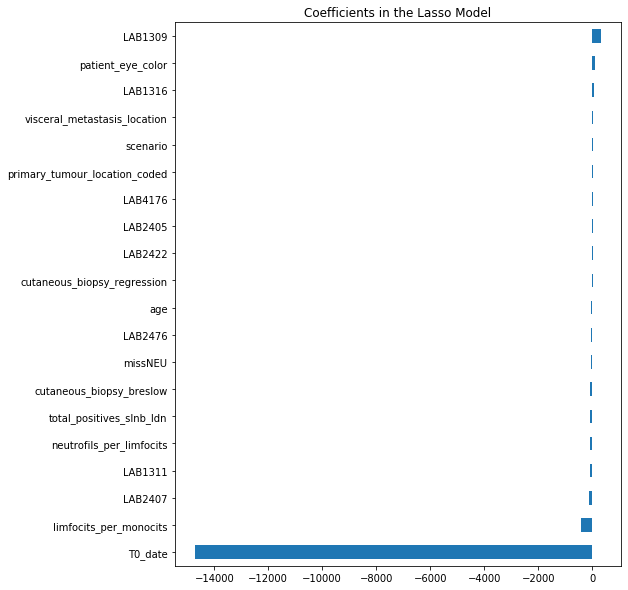

In [5]:
coefs = Lasso_importance(X_train, y_train['months_survival']) #coef of each feature in the linear regression

Notice that it says that Lasso set two features to 0 out of a total of 54 features. In other words, two features had null coefficients.<br>
Finally, we can see a bar plot displaying the values of the coefficient for 20 features. The first 10 features are the ones with lower coefficients (sorted in an ascending way). The other 10 are the ones with higher coefficients (also sorted in an ascending way).

Using the previous information, we will just keep the features with positive coefficients.

In [6]:
coefs.sort_values(ascending=False, inplace=True)
selected_columns = coefs[np.abs(coefs)>0].index
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

# Define the Cox model

In order to be able to create the Cox model, we need to split the *y_train* and *y_test* into the *T* (time) and *D* (death) labels.  

In [7]:
T_train, T_test = y_train['months_survival'].values, y_test['months_survival'].values
D_train, D_test = y_train['specific_death'].values, y_test['specific_death'].values

Let us now build the model.

In [8]:
coxph = CoxPHModel()
estimator = coxph.fit(X_train, T_train, D_train, lr=0.35, l2_reg=1e-2, init_method='zeros')

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 2115.410 - ||grad||^2 = 690.59900
 * Iteration #2 - Loss = 2604.348 - ||grad||^2 = 1780.29471
 * Iteration #3 - Loss = 2021.501 - ||grad||^2 = 350.15254
 * Iteration #4 - Loss = 1985.493 - ||grad||^2 = 1031.66926
 * Iteration #5 - Loss = 1877.481 - ||grad||^2 = 137.16174
 * Iteration #6 - Loss = 1885.502 - ||grad||^2 = 668.66767
 * Iteration #7 - Loss = 1867.528 - ||grad||^2 = 415.97738
 * Iteration #8 - Loss = 1860.689 - ||grad||^2 = 278.53219
 * Iteration #9 - Loss = 1857.315 - ||grad||^2 = 189.35442
 * Iteration #10 - Loss = 1855.531 - ||grad||^2 = 129.29732
 * Iteration #11 - Loss = 1854.558 - ||grad||^2 = 88.24573
 * Iteration #12 - Loss = 1854.025 - ||grad||^2 = 60.02111
 * Iteration #13 - Loss = 1853.736 - ||grad||^2 = 40.60562
 * Iteration #14 - Loss = 1853.584 - ||grad||^2 = 27.29413
 * Iteration #15 - Loss = 1853.506 - ||grad||^2 = 18.22334
 * Iteration #16 - Loss = 1853.468 - ||grad||^2 = 12.09030
 * Iteration #

# Metrics

### Concordance Index

First of all, we are going to check the *concordance index (C_index)*. It measures whether the predicted order of patient's deaths corresponds to the true order of deaths. C_index=1 would be a perfect match (in the order) and C_index=0 would be that we have missed all of them.<br>
Reference for the C_index: https://medium.com/analytics-vidhya/concordance-index-72298c11eac7

In [9]:
c_index = concordance_index(coxph,  X_test.values, T_test, D_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.81


### Integrated Brier Score

The *Integrated Brier Score (IBS)* is a way of computing the error between the survival probability at time *t* of an individual and its ground truth at time *t*. The BS computes such error for each *t* whereas the IBS computes the integral of the BS curve. IBS=0 would mean perfect match. <br>
Reference for the IBS (and its implementation): https://square.github.io/pysurvival/metrics/brier_score.html

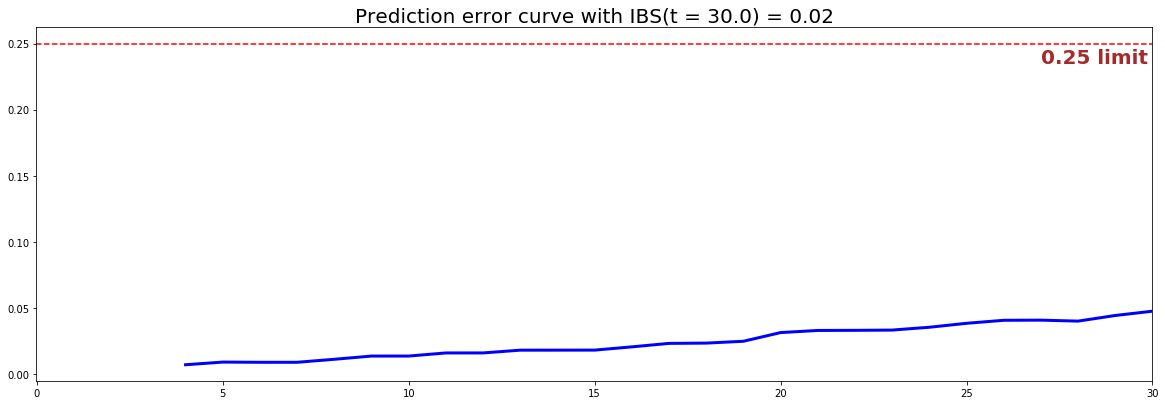

IBS: 0.02


In [10]:
#Plot the BS curve and gives the integral under the curve (IBS)
ibs = integrated_brier_score(coxph, X_test.values, T_test, D_test, t_max=30, figure_size=(20, 6.5))
print('IBS: {:.2f}'.format(ibs))

### Brier Score with Inverse Probability Censoring Weights

It is defined as 
$$
ErrorScore = \frac{1}{NT}\sum_{i=1}^N\sum_{j=1}^T w_i(t_j)|\hat{Y}_i(t_j)-Y_i(t_j)|^2
$$

Let us now find it.

**1. Compute the predictions $\hat{Y}$**.

In [11]:
#Function that returns the predicted values (values of the survival curve) for each patient of the input x_test

def get_predictions(x_test, estimator):
    
    # Create an empty pandas dataframes with these times as the columns
    pred = estimator.predict_survival(x_test.values[0, :]).flatten()
    print(pred.shape)
    times = np.arange(pred.shape[0])
    pred_df = pd.DataFrame(columns = times )
    
    # Convert each row to a pandas series row (transpose) with the index as these x times and append it to the df
    for i in range(0,len(x_test)):
        pred = estimator.predict_survival(x_test.values[i, :])
        pred_df = pred_df.append(pd.DataFrame(pred)) 

    pred_df = pred_df.set_index(np.arange(pred_df.shape[0]))

    return pred_df,times

In [12]:
predictions, times = get_predictions(X_test, estimator)

(105,)


**2. Compute the weights.**

In [13]:
weights = error_function.calc_weights(y_test) 

**3. Compute the error.**

In [14]:
error = error_function.brier_score_loss_weighted(pred = predictions, actual = y_test, weights = weights)
print("Overall error: ", error)

Overall error:  0.05736018654864291


# Retrain the model using both the training and test sets.

In [18]:
#Retrain model with train + test sets

X_data = pd.concat([X_train, X_test])
y_data = pd.concat([y_train, y_test])
T_data = y_data['months_survival'].values
D_data = y_data['specific_death'].values

estimator = coxph.fit(X_data, T_data, D_data, lr=0.15, l2_reg=1e-2, init_method='zeros')

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 2708.402 - ||grad||^2 = 863.13152
 * Iteration #2 - Loss = 2611.448 - ||grad||^2 = 1007.35222
 * Iteration #3 - Loss = 2491.209 - ||grad||^2 = 646.82544
 * Iteration #4 - Loss = 2457.002 - ||grad||^2 = 544.84558
 * Iteration #5 - Loss = 2434.908 - ||grad||^2 = 461.35702
 * Iteration #6 - Loss = 2419.856 - ||grad||^2 = 391.84051
 * Iteration #7 - Loss = 2409.221 - ||grad||^2 = 333.41990
 * Iteration #8 - Loss = 2401.422 - ||grad||^2 = 284.04525
 * Iteration #9 - Loss = 2395.628 - ||grad||^2 = 242.16562
 * Iteration #10 - Loss = 2391.394 - ||grad||^2 = 206.56259
 * Iteration #11 - Loss = 2388.290 - ||grad||^2 = 176.24614
 * Iteration #12 - Loss = 2386.004 - ||grad||^2 = 150.40175
 * Iteration #13 - Loss = 2384.317 - ||grad||^2 = 128.35220
 * Iteration #14 - Loss = 2383.069 - ||grad||^2 = 109.53018
 * Iteration #15 - Loss = 2382.145 - ||grad||^2 = 93.45786
 * Iteration #16 - Loss = 2381.461 - ||grad||^2 = 79.73109
 * Iteratio

Let us now plot the survival curve so as to check that we have obtained reasonable results.

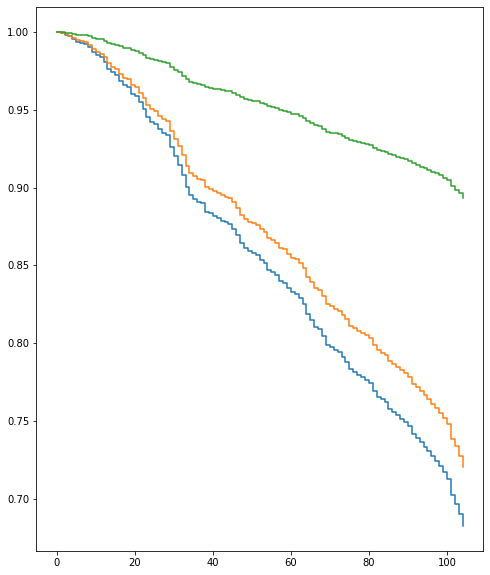

In [19]:
# Plot survival curves for certain observations (here we take first 3 observations)
for curve in predictions.values[0:3]:
    plt.step(times, curve, where="post")

# Save the information regarding the model

In [21]:
from pysurvival.utils import save_model
save_model(estimator, '/home/vant/Tera/Assignatures/AgileDataScience/Project/Nuria/Cox_model.zip')

pd.DataFrame(selected_columns).to_csv("Features_Cox_model.csv")

Saving the model to disk as /home/vant/Tera/Assignatures/AgileDataScience/Project/Nuria/Cox_model.zip
